# Getting Started: Counterfactual Generation with [UCI Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail) Data

We demonstrate how AdaRec works with a customer-level dataset with `promotion` containing the treatment they are given. In our example, we will use `No Promotion` to be able to cross-validate with actual outcomes in the dataset which had not promotion. We also divide the dataset into 1,000 customers for inference and 2,000 customers for retrieving few-shot examples. Lastly, we demonstrate how AdaRec can perform recommendation by first generating ideal product description which can be semantically matched to the most likely product descriptions in the product catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [103]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.data_processing.transform import (
    convert_to_float,
    impute_cols,
    winsorize_col,
    resample_by_outcome,
    train_valid_test_split,
)
from src.counterfactual.base_profile_generator import BaseProfileGenerator
import yaml
import textwrap

def pretty_print(profile_text, width=80):
    """
    Print customer profile with text wrapping to fit in notebook cell.
    
    Args:
        profile_text (str): The profile text to format
        width (int): Maximum line width (default 80 characters)
    """
    lines = profile_text.split('\n')
    
    for line in lines:
        if line.strip():
            # Wrap long lines
            wrapped_lines = textwrap.fill(line, width=width, 
                                        subsequent_indent='  ',
                                        break_long_words=False,
                                        break_on_hyphens=False)
            print(wrapped_lines)
        else:
            print()  # Preserve empty lines

## Load Dataset

In [14]:
df = pl.read_csv('../data/uci_online_retail.csv')
df = df.with_columns(
    pl.lit('No Promotion').alias('promotion'), #add dummy treatment column
    pl.lit('Dummy Description').alias('TargetDescription'), #add dummy outcome column
    pl.col('CustomerID').alias('customer_id').cast(pl.Utf8), #make sure the identifier is called `customer_id`
)
df = winsorize_col(df, 'TargetSales', q=0.99) #winsorize outcome at 99th percentile

#randomize then select
df = df.sample(fraction=.999, seed=112)
infer_df = df[:1000] #first 1000 customers to do inference on
ref_df = df[1000:] #the rest of the customers to serve as reference set for few-shot examples

infer_df.tail()

CustomerID,TargetSales,TargetDescriptions,TargetCategories,bought_descriptions,bought_categories,recency,purchase_day,total_sales,nb_product,nb_category,customer_lifetime,avg_purchase_frequency,avg_purchase_value,per_fashion_accessories,per_home_decor,per_kitchen_and_dining,per_others,per_outdoor_and_garden,per_personal_care_and_wellness,per_seasonal_and_holiday,per_stationary_and_gifts,per_toys_and_games,promotion,TargetDescription,customer_id
i64,f64,str,str,str,str,i64,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
12790,0.0,null,null,"""MINI JIGSAW DOLLY GIRL|CARD DO…","""Toys and Games|Stationary and …",122,1,294.92,20,4,122,122.0,294.92,0.0,0.291605,0.44351,0.0,0.0,0.0,0.0,0.068358,0.196528,"""No Promotion""","""Dummy Description""","""12790"""
15831,350.65,"""VINTAGE SNAKES & LADDERS|VINTA…","""Toys and Games|Home Decor|Pers…","""DECORATIVE ROSE BATHROOM BOTTL…","""Personal Care and Wellness|Hom…",54,2,451.11,22,7,254,127.0,225.555,0.010973,0.632462,0.026402,0.0,0.0,0.052005,0.148744,0.08315,0.046264,"""No Promotion""","""Dummy Description""","""15831"""
17572,0.0,null,null,"""GRAND CHOCOLATECANDLE|PINK REG…","""Home Decor|Kitchen and Dining|…",0,3,155.95,6,3,168,56.0,51.983333,0.0,0.418403,0.354601,0.0,0.0,0.226996,0.0,0.0,0.0,"""No Promotion""","""Dummy Description""","""17572"""
16642,380.6,"""PLASMATRONIC LAMP|SWIRLY CIRCU…","""Home Decor|Stationary and Gift…","""WHITE WOOD GARDEN PLANT LADDER…","""Outdoor and Garden|Home Decor|…",137,1,307.73,15,4,137,137.0,307.73,0.048744,0.458454,0.0,0.0,0.444058,0.0,0.048744,0.0,0.0,"""No Promotion""","""Dummy Description""","""16642"""
14690,154.99,"""HAND OVER THE CHOCOLATE SIGN…","""Home Decor|Stationary and Gift…","""COFFEE MUG DOG + BALL DESIGN|D…","""Kitchen and Dining|Others|Toys…",81,1,216.71,28,6,81,81.0,216.71,0.0,0.625767,0.159199,0.029071,0.019381,0.0,0.0,0.128282,0.0383,"""No Promotion""","""Dummy Description""","""14690"""


In [15]:
#in this example, we use dummy promotion but you can use whatever promo you want
infer_df['promotion'].value_counts(normalize=True).sort('promotion')

promotion,proportion
str,f64
"""No Promotion""",1.0


## Generate Template Profiles

Convert tabular data into template text paragraphs.

In [16]:
#treatment_config and outcome_config are optional to generate template profiles
generator = BaseProfileGenerator(
    df=infer_df,
    feature_config='../config/customer_feature_config.yaml', #path to feature config to generate profiles
    treatment_config='../config/treatment_config.yaml', #path to treatment config to describe treatment
    outcome_config='../config/outcome_config.yaml',  #path to treatment config to describe outcome
    feature_distribution_exclude_cols = ['bought_descriptions'], #columns to exclude from calculating feature distribution
)

# Access template profiles
template_profiles = generator.template_profile_dataset

100%|██████████| 1000/1000 [00:00<00:00, 34485.83it/s]


In [17]:
template_profiles[67]

{'customer_id': '13867',
 'template_profile': "[Membership Domain] Number of days since first purchase: 147.\n[Purchase History Domain] Product descriptions of previously purchased items: 12 PENCILS TALL TUBE RED RETROSPOT|RED RETROSPOT MINI CASES|ENAMEL FLOWER JUG CREAM|WHITE HANGING HEART T-LIGHT HOLDER|DOORMAT UNION FLAG|CREAM SWEETHEART MINI CHEST|WOOD BLACK BOARD ANT WHITE FINISH|PICNIC BASKET WICKER LARGE|PIGGY BANK RETROSPOT |GINGHAM HEART DECORATION|STRAWBERRY CERAMIC TRINKET BOX|HEART OF WICKER SMALL|ROLL WRAP 50'S CHRISTMAS|ROLL WRAP 50'S RED CHRISTMAS |ROLL WRAP VINTAGE CHRISTMAS|ROLL WRAP VINTAGE SPOT |RED SPOT PAPER GIFT BAG| RED SPOT GIFT BAG LARGE|15CM CHRISTMAS GLASS BALL 20 LIGHTS| 50'S CHRISTMAS GIFT BAG LARGE|50'S CHRISTMAS PAPER GIFT BAG|6 GIFT TAGS 50'S CHRISTMAS |HANGING METAL HEART LANTERN|LANTERN CREAM GAZEBO |PLEASE ONE PERSON METAL SIGN|WOODEN HEART CHRISTMAS SCANDINAVIAN|HOME SWEET HOME HANGING HEART|HOME SWEET HOME CUSHION COVER |ENAMEL BREAD BIN CREAM|PARIS

In [18]:
pretty_print(template_profiles[67]['template_profile'])

[Membership Domain] Number of days since first purchase: 147.
[Purchase History Domain] Product descriptions of previously purchased items: 12
  PENCILS TALL TUBE RED RETROSPOT|RED RETROSPOT MINI CASES|ENAMEL FLOWER JUG
  CREAM|WHITE HANGING HEART T-LIGHT HOLDER|DOORMAT UNION FLAG|CREAM SWEETHEART
  MINI CHEST|WOOD BLACK BOARD ANT WHITE FINISH|PICNIC BASKET WICKER LARGE|PIGGY
  BANK RETROSPOT |GINGHAM HEART DECORATION|STRAWBERRY CERAMIC TRINKET BOX|HEART
  OF WICKER SMALL|ROLL WRAP 50'S CHRISTMAS|ROLL WRAP 50'S RED CHRISTMAS |ROLL
  WRAP VINTAGE CHRISTMAS|ROLL WRAP VINTAGE SPOT |RED SPOT PAPER GIFT BAG| RED
  SPOT GIFT BAG LARGE|15CM CHRISTMAS GLASS BALL 20 LIGHTS| 50'S CHRISTMAS GIFT
  BAG LARGE|50'S CHRISTMAS PAPER GIFT BAG|6 GIFT TAGS 50'S CHRISTMAS |HANGING
  METAL HEART LANTERN|LANTERN CREAM GAZEBO |PLEASE ONE PERSON METAL SIGN|WOODEN
  HEART CHRISTMAS SCANDINAVIAN|HOME SWEET HOME HANGING HEART|HOME SWEET HOME
  CUSHION COVER |ENAMEL BREAD BIN CREAM|PARISIENNE JEWELLERY DRAWER |LA

In [19]:
#feature distribution
pretty_print(generator.feature_distribution)

[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99.60%
- Mean: 168
- Percentiles:
  10th: 37
  20th: 94
  30th: 133
  40th: 168
  50th: 186
  60th: 206
  70th: 225
  80th: 245
  90th: 260
[Recency Domain]
Distribution of Number of days since customer's last purchase:
- Range: 0 to 268
- Percent of non-zero values: 97.40%
- Mean: 79
- Percentiles:
  10th: 4
  20th: 10
  30th: 19
  40th: 35
  50th: 58
  60th: 85
  70th: 115
  80th: 148
  90th: 194
[Frequency Domain]
Distribution of Number of purchase days:
- Range: 1 to 119
- Percent of non-zero values: 100.00%
- Mean: 3
- Percentiles:
  10th: 1
  20th: 1
  30th: 1
  40th: 1
  50th: 2
  60th: 3
  70th: 3
  80th: 4
  90th: 7
Distribution of Average days between purchases:
- Range: 0.00 to 268.00
- Percent of non-zero values: 99.60%
- Mean: 82.68
- Percentiles:
  10th: 16.55
  20th: 30.25
  30th: 40.83
  40th: 51.50
  50th: 63.67
  60th: 80.00
  70th: 101.00
  80th: 1

## Generate Narrative Profiles

Convert template text paragraphs into a narrative profile. 

In [20]:
from src.counterfactual import BatchProfileGenerator

#treatment_config and outcome_config are also optional for generating narrative profiles
batch_generator = BatchProfileGenerator(
    df=infer_df,
    model_config='../config/model_config.yaml', #path to model config containing prompts and hyperparams
    feature_config='../config/customer_feature_config.yaml', #path to feature config to generate profiles
    treatment_config='../config/treatment_config.yaml', #path to treatment config to describe treatment
    outcome_config='../config/outcome_config.yaml',  #path to treatment config to describe outcome
    feature_distribution_exclude_cols = ['bought_descriptions'], #columns to exclude from calculating feature distribution
    row_limit=100 #limit for debugging
)

narrative_profiles = batch_generator.generate_batch_narrative_profiles(
    append_template=True, #append template after narrative profile
    debug_prompts=True #show actual prompts and # tokens sent for each batch
    )

100%|██████████| 100/100 [00:00<00:00, 36424.70it/s]


Generating narrative profiles for 100 customers
Batch size: 20, Chunk size: 10, Workers: 2
Expected throughput: ~4.0 profiles/second


Processing batch windows:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 14503, 14930, 12609, 17548, 14359, 14375, 17193, 14951, 15118, 15370
Estimated tokens: ~6,941

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99.60%
- Mean: 168
- Percentiles:
  10th: 37
  20th:

Processing batch windows:  20%|██        | 1/5 [01:10<04:40, 70.20s/it]

Batch window completed in 70.2s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 18080, 14271, 16743, 17152, 14191, 13918, 15453, 18177, 13082, 14525
Estimated tokens: ~7,720

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  40%|████      | 2/5 [02:19<03:29, 69.80s/it]

Batch window completed in 69.5s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 15197, 16093, 15051, 17217, 14079, 14931, 12540, 16545, 14264, 14340
Estimated tokens: ~6,218

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  60%|██████    | 3/5 [03:35<02:25, 72.71s/it]

Batch window completed in 76.2s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 14423, 12981, 15238, 14727, 13253, 12840, 15034, 14691, 13047, 14823
Estimated tokens: ~7,824

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  80%|████████  | 4/5 [04:49<01:13, 73.02s/it]

Batch window completed in 73.5s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 12584, 15825, 15257, 15528, 13456, 12940, 12353, 18161, 16814, 14334
Estimated tokens: ~6,382

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows: 100%|██████████| 5/5 [06:19<00:00, 75.86s/it]

Batch window completed in 89.9s (no sleep needed)
Appending template profiles to narrative profiles...
Generated 100 narrative profiles with templates appended


In [24]:
batch_generator.template_profile_dataset[67]

{'customer_id': '14691',
 'template_profile': "[Membership Domain] Number of days since first purchase: 142.\n[Purchase History Domain] Product descriptions of previously purchased items: DOORMAT KEEP CALM AND COME IN|DOORMAT NEW ENGLAND|DOORMAT SPOTTY HOME SWEET HOME|HERB MARKER MINT|HERB MARKER CHIVES |HERB MARKER ROSEMARY|HERB MARKER BASIL|HERB MARKER PARSLEY|HERB MARKER THYME|BLUE GIANT GARDEN THERMOMETER|GREEN GIANT GARDEN THERMOMETER|LE GRAND TRAY CHIC SET|JUMBO BAG ALPHABET|JUMBO BAG DOILEY PATTERNS|LUNCH BAG ALPHABET DESIGN|LUNCH BAG DOILEY PATTERN |JUMBO SHOPPER VINTAGE RED PAISLEY|SET 12 KIDS COLOUR  CHALK STICKS|LOVE HOT WATER BOTTLE|HOT WATER BOTTLE KEEP CALM|HOT WATER BOTTLE TEA AND SYMPATHY|HOT WATER BOTTLE I AM SO POORLY|LUNCH BAG VINTAGE DOILY |JUMBO BAG APPLES|LUNCH BAG APPLE DESIGN|PLEASE ONE PERSON METAL SIGN|GIN + TONIC DIET METAL SIGN|COOK WITH WINE METAL SIGN |DOORMAT ENGLISH ROSE |ZINC HERB GARDEN CONTAINER|VINTAGE  2 METER FOLDING RULER|CREAM SWEETHEART MINI CHE

In [25]:
batch_generator.narrative_profile_dataset[67]

{'customer_id': '14691',
 'template_profile': "[Membership Domain] Number of days since first purchase: 142.\n[Purchase History Domain] Product descriptions of previously purchased items: DOORMAT KEEP CALM AND COME IN|DOORMAT NEW ENGLAND|DOORMAT SPOTTY HOME SWEET HOME|HERB MARKER MINT|HERB MARKER CHIVES |HERB MARKER ROSEMARY|HERB MARKER BASIL|HERB MARKER PARSLEY|HERB MARKER THYME|BLUE GIANT GARDEN THERMOMETER|GREEN GIANT GARDEN THERMOMETER|LE GRAND TRAY CHIC SET|JUMBO BAG ALPHABET|JUMBO BAG DOILEY PATTERNS|LUNCH BAG ALPHABET DESIGN|LUNCH BAG DOILEY PATTERN |JUMBO SHOPPER VINTAGE RED PAISLEY|SET 12 KIDS COLOUR  CHALK STICKS|LOVE HOT WATER BOTTLE|HOT WATER BOTTLE KEEP CALM|HOT WATER BOTTLE TEA AND SYMPATHY|HOT WATER BOTTLE I AM SO POORLY|LUNCH BAG VINTAGE DOILY |JUMBO BAG APPLES|LUNCH BAG APPLE DESIGN|PLEASE ONE PERSON METAL SIGN|GIN + TONIC DIET METAL SIGN|COOK WITH WINE METAL SIGN |DOORMAT ENGLISH ROSE |ZINC HERB GARDEN CONTAINER|VINTAGE  2 METER FOLDING RULER|CREAM SWEETHEART MINI CHE

In [26]:
pretty_print(batch_generator.narrative_profile_dataset[67]['narrative_profile'])

Customer 14691 is a highly engaged customer with 142 days of membership (30th
  percentile) and four purchase occasions. Their most recent purchase was just 1
  day ago, placing them at the 10th percentile for recency and indicating peak
  current engagement. With total sales of £1,769.07 (80th percentile) and an
  average basket size of £442.27 (50th percentile), they demonstrate strong
  monetary value. They've purchased 50 distinct products across 8 categories -
  maximum category breadth - showing exceptional product exploration. Their
  category preferences are remarkably balanced: Home Decor (37.7%), Kitchen and
  Dining (10.7%), Stationary and Gifts (10.7%), Fashion Accessories (10.3%),
  Personal Care (10.4%), Seasonal/Holiday (9.8%), Outdoor and Garden (9.5%), and
  Toys and Games (0.8%). The purchase history reveals interest in doormats, herb
  markers, garden items, lunch bags, hot water bottles, and decorative signs
  with humorous or inspirational messages. Their purchase 

## Generate Reference Dataset

Do the same for reference dataset where we will retrieve few-shot examples from. In practice, this is usually a separate historical dataset but in this example we split from the main dataset.

In [27]:
from src.counterfactual import BatchProfileGenerator

#treatment_config and outcome_config are also optional for generating narrative profiles
ref_batch_generator = BatchProfileGenerator(
    df=ref_df,
    model_config='../config/model_config.yaml', #path to model config containing prompts and hyperparams
    feature_config='../config/customer_feature_config.yaml', #path to feature config to generate profiles
    treatment_config='../config/treatment_config.yaml', #path to treatment config to describe treatment
    outcome_config='../config/outcome_config.yaml',  #path to treatment config to describe outcome
    feature_distribution_exclude_cols = ['bought_descriptions'], #columns to exclude from calculating feature distribution
    row_limit=100 #limit for debugging
)

ref_narrative_profiles = ref_batch_generator.generate_batch_narrative_profiles(
    append_template=True,
    debug_prompts=True)

100%|██████████| 100/100 [00:00<00:00, 35089.97it/s]


Generating narrative profiles for 100 customers
Batch size: 20, Chunk size: 10, Workers: 2
Expected throughput: ~4.0 profiles/second


Processing batch windows:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 17427, 16866, 16159, 13488, 14824, 14689, 13557, 17800, 13126, 16735
Estimated tokens: ~7,451

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99.38%
- Mean: 165
- Percentiles:
  10th: 36
  20th:

Processing batch windows:  20%|██        | 1/5 [01:24<05:36, 84.21s/it]

Batch window completed in 84.2s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 16620, 15809, 13700, 15341, 12379, 15136, 12829, 17698, 13005, 12412
Estimated tokens: ~6,270

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  40%|████      | 2/5 [02:55<04:24, 88.25s/it]

Batch window completed in 91.1s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 15129, 15005, 17686, 15895, 14472, 16268, 14760, 17750, 13936, 14960
Estimated tokens: ~9,781

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  60%|██████    | 3/5 [04:19<02:52, 86.18s/it]

Batch window completed in 83.7s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 18273, 15048, 13975, 13815, 14548, 13809, 15079, 13804, 12700, 16386
Estimated tokens: ~8,264

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 99

Processing batch windows:  80%|████████  | 4/5 [06:01<01:32, 92.73s/it]

Batch window completed in 102.8s (no sleep needed)
Processing 20 profiles in 2 parallel chunks

PROFILE GENERATION PROMPT DEBUG
Customer IDs: 16961, 12814, 18261, 13263, 12919, 17816, 15707, 16755, 15222, 12599
Estimated tokens: ~8,420

SYSTEM PROMPT:
You are a professional customer profile analyst at Big Retail. Your task is to create 
clear, concise narratives describing customer profiles based on their behavioral data and 
feature distributions. The profiles should be informative and suitable for predicting 
customer responses to promotional campaigns. Referring to feature distribution of all customers,
Generate natural, flowing narratives that incorporate key behavioral insights while maintaining 
readability and coherence. We are going to use this profile to determine how each customer 
behaves organically or in response to a promotion.


FEATURE DISTRIBUTION:
[Membership Domain]
Distribution of Number of days since first purchase:
- Range: 0 to 269
- Percent of non-zero values: 9

Processing batch windows: 100%|██████████| 5/5 [07:08<00:00, 85.72s/it]

Batch window completed in 66.8s (no sleep needed)
Appending template profiles to narrative profiles...
Generated 100 narrative profiles with templates appended


In [28]:
ref_narrative_profiles[67]

{'customer_id': '13804',
 'template_profile': '[Membership Domain] Number of days since first purchase: 219.\n[Purchase History Domain] Product descriptions of previously purchased items: GLASS CLOCHE SMALL|GLASS CLOCHE LARGE|SWEETHEART CAKESTAND 3 TIER|BREAD BIN DINER STYLE MINT|PHARMACIE FIRST AID TIN|FRIDGE MAGNETS LA VIE EN ROSE|SWEETHEART CERAMIC TRINKET BOX|CERAMIC CAKE STAND + HANGING CAKES|MINI CAKE STAND WITH HANGING CAKES|CERAMIC STRAWBERRY CAKE MONEY BANK|CERAMIC PLATE STRAWBERRY DESIGN|CERAMIC STRAWBERRY DESIGN MUG|PACK OF 72 RETROSPOT CAKE CASES|SET OF 72 RETROSPOT PAPER  DOILIES|SET OF 6 SPICE TINS PANTRY DESIGN|RECIPE BOX PANTRY YELLOW DESIGN|SET OF 3 CAKE TINS PANTRY DESIGN |HOMEMADE JAM SCENTED CANDLES|PANTRY SCRUBBING BRUSH|PANTRY ROLLING PIN|JAM MAKING SET WITH JARS|GINGERBREAD MAN COOKIE CUTTER|VINTAGE UNION JACK BUNTING|BLUE HARMONICA IN BOX |VINTAGE SNAKES & LADDERS|BINGO SET|WORLD WAR 2 GLIDERS ASSTD DESIGNS|WOODEN BOX OF DOMINOES|WOODEN SCHOOL COLOURING SET|SEAS

In [29]:
ref_batch_generator.narrative_profile_dataset[67]

{'customer_id': '13804',
 'template_profile': '[Membership Domain] Number of days since first purchase: 219.\n[Purchase History Domain] Product descriptions of previously purchased items: GLASS CLOCHE SMALL|GLASS CLOCHE LARGE|SWEETHEART CAKESTAND 3 TIER|BREAD BIN DINER STYLE MINT|PHARMACIE FIRST AID TIN|FRIDGE MAGNETS LA VIE EN ROSE|SWEETHEART CERAMIC TRINKET BOX|CERAMIC CAKE STAND + HANGING CAKES|MINI CAKE STAND WITH HANGING CAKES|CERAMIC STRAWBERRY CAKE MONEY BANK|CERAMIC PLATE STRAWBERRY DESIGN|CERAMIC STRAWBERRY DESIGN MUG|PACK OF 72 RETROSPOT CAKE CASES|SET OF 72 RETROSPOT PAPER  DOILIES|SET OF 6 SPICE TINS PANTRY DESIGN|RECIPE BOX PANTRY YELLOW DESIGN|SET OF 3 CAKE TINS PANTRY DESIGN |HOMEMADE JAM SCENTED CANDLES|PANTRY SCRUBBING BRUSH|PANTRY ROLLING PIN|JAM MAKING SET WITH JARS|GINGERBREAD MAN COOKIE CUTTER|VINTAGE UNION JACK BUNTING|BLUE HARMONICA IN BOX |VINTAGE SNAKES & LADDERS|BINGO SET|WORLD WAR 2 GLIDERS ASSTD DESIGNS|WOODEN BOX OF DOMINOES|WOODEN SCHOOL COLOURING SET|SEAS

In [31]:
pretty_print(ref_batch_generator.narrative_profile_dataset[67]['narrative_profile'])

This customer is a highly valuable, well-established member who joined 219 days
  ago, placing them in the 60th-70th percentile for tenure. They've made 5
  purchases with their most recent transaction just 8 days ago, indicating
  excellent recency in the top 10th percentile. Their average of 43.8 days
  between purchases demonstrates strong engagement, shopping significantly more
  frequently than the typical customer's 65-day interval, placing them above the
  70th percentile for frequency. With total spending of $2,282.98 and an average
  basket size of $456.60, they rank between the 80th and 90th percentiles for
  monetary value, making them a high-value customer. They've purchased an
  impressive 114 distinct products across 8 categories (the maximum observed),
  placing them well above the 90th percentile for product diversity. Their
  category distribution shows strong preference for Kitchen and Dining (38.3%),
  followed by Home Decor (19.0%), Toys and Games (16.8%), Seasonal 

## Generate Predictions

Generate counterfactual predictions on `TargetSales` given the narrative profiles and compare it to gradient boosted trees trained on the reference dataset. Additionally, we also let the model generate `TargetDescription` of the ideal product to recommend to this customer.

In [32]:
from src.counterfactual.batch_predictor import BatchPredictor

#only a few features to look up similar customers; in this case the simple RFM
sim_features = [
    'recency',
    'purchase_day',
    'total_sales',
]

# Initialize with your dataset
predictor = BatchPredictor(
    generator=batch_generator, #generator of dataset to make predictions on
    customer_profile_column='narrative_profile', #specify which type of profiles to use
    outcome_config = '../config/outcome_config.yaml', #config about the outcome
    model_config = '../config/model_config.yaml', #prompts about the prediction
    outcome_context="The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.", #additional contexts for outcome predictions as needed
    outcome_distribution_exclude_cols='TargetDescription', #outcome column to exclude from outcome distribution
    reference_generator=ref_batch_generator, #reference dataset to perform few-shot learning from
    similarity_features=sim_features, #which features used to look up similar customers
    top_k_examples=3, #number of few-shot examples per customer to use as reference
)

# Generate predictions
predicted_dataset = predictor.generate_predictions(debug_prompts=True)

Generating counterfactual predictions for 100 customers
Batch size: 20, Chunk size: 10, Workers: 2
Expected throughput: ~4.0 predictions/second


Processing batch windows:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 20 customers in 2 parallel chunks



COUNTERFACTUAL PREDICTION PROMPT DEBUG
Customer IDs: 14503, 14930, 12609, 17548, 14359, 14375, 17193, 14951, 15118, 15370
Estimated tokens: ~40,015
Has outcome distribution: True
Has similar examples: True

SYSTEM PROMPT:
You are a Senior Marketing Analyst at Big Retail specializing in customer behavior prediction.
Your task is to predict if and how much a customer would purchase based on their profiles. 
Consider factors like shopping patterns, basket size, engagement levels, loyalty indicators, 
and promotional responsiveness. Provide structured predictions including outcome predictions,
confidence level and reasoning. Consider outcome distribution for organic behaviors of the customers 
and deduce how would they behave given the treatments.

OUTCOME DISTRIBUTION:
The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.

Distribution of Sales during period of interest:
- Range: 0.00 to 13099.29
- P

Processing batch windows:  20%|██        | 1/5 [01:25<05:40, 85.15s/it]

Batch window completed in 85.1s (no sleep needed)
Processing 20 customers in 2 parallel chunks



COUNTERFACTUAL PREDICTION PROMPT DEBUG
Customer IDs: 18080, 14271, 16743, 17152, 14191, 13918, 15453, 18177, 13082, 14525
Estimated tokens: ~45,953
Has outcome distribution: True
Has similar examples: True

SYSTEM PROMPT:
You are a Senior Marketing Analyst at Big Retail specializing in customer behavior prediction.
Your task is to predict if and how much a customer would purchase based on their profiles. 
Consider factors like shopping patterns, basket size, engagement levels, loyalty indicators, 
and promotional responsiveness. Provide structured predictions including outcome predictions,
confidence level and reasoning. Consider outcome distribution for organic behaviors of the customers 
and deduce how would they behave given the treatments.

OUTCOME DISTRIBUTION:
The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.

Distribution of Sales during period of interest:
- Range: 0.00 to 13099.29
- P

Processing batch windows:  40%|████      | 2/5 [02:32<03:44, 74.93s/it]

Batch window completed in 67.8s (no sleep needed)
Processing 20 customers in 2 parallel chunks



COUNTERFACTUAL PREDICTION PROMPT DEBUG
Customer IDs: 15912, 12823, 16809, 18037, 13717, 12402, 17164, 13124, 14055, 14206
Estimated tokens: ~40,384
Has outcome distribution: True
Has similar examples: True

SYSTEM PROMPT:
You are a Senior Marketing Analyst at Big Retail specializing in customer behavior prediction.
Your task is to predict if and how much a customer would purchase based on their profiles. 
Consider factors like shopping patterns, basket size, engagement levels, loyalty indicators, 
and promotional responsiveness. Provide structured predictions including outcome predictions,
confidence level and reasoning. Consider outcome distribution for organic behaviors of the customers 
and deduce how would they behave given the treatments.

OUTCOME DISTRIBUTION:
The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.

Distribution of Sales during period of interest:
- Range: 0.00 to 13099.29
- P

Processing batch windows:  60%|██████    | 3/5 [03:38<02:21, 70.80s/it]

Batch window completed in 65.9s (no sleep needed)
Processing 20 customers in 2 parallel chunks



COUNTERFACTUAL PREDICTION PROMPT DEBUG
Customer IDs: 14423, 12981, 15238, 14727, 13253, 12840, 15034, 14691, 13047, 14823
Estimated tokens: ~42,226
Has outcome distribution: True
Has similar examples: True

SYSTEM PROMPT:
You are a Senior Marketing Analyst at Big Retail specializing in customer behavior prediction.
Your task is to predict if and how much a customer would purchase based on their profiles. 
Consider factors like shopping patterns, basket size, engagement levels, loyalty indicators, 
and promotional responsiveness. Provide structured predictions including outcome predictions,
confidence level and reasoning. Consider outcome distribution for organic behaviors of the customers 
and deduce how would they behave given the treatments.

OUTCOME DISTRIBUTION:
The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.

Distribution of Sales during period of interest:
- Range: 0.00 to 13099.29
- P

Processing batch windows:  80%|████████  | 4/5 [04:54<01:12, 72.63s/it]

Batch window completed in 75.4s (no sleep needed)
Processing 20 customers in 2 parallel chunks



COUNTERFACTUAL PREDICTION PROMPT DEBUG
Customer IDs: 12809, 12407, 13502, 12615, 13814, 15266, 16619, 16592, 15729, 16213
Estimated tokens: ~39,340
Has outcome distribution: True
Has similar examples: True

SYSTEM PROMPT:
You are a Senior Marketing Analyst at Big Retail specializing in customer behavior prediction.
Your task is to predict if and how much a customer would purchase based on their profiles. 
Consider factors like shopping patterns, basket size, engagement levels, loyalty indicators, 
and promotional responsiveness. Provide structured predictions including outcome predictions,
confidence level and reasoning. Consider outcome distribution for organic behaviors of the customers 
and deduce how would they behave given the treatments.

OUTCOME DISTRIBUTION:
The following statistics represent customer behavior when NO promotions are active. These serve as the baseline for counterfactual prediction.

Distribution of Sales during period of interest:
- Range: 0.00 to 13099.29
- P

Processing batch windows: 100%|██████████| 5/5 [06:27<00:00, 77.44s/it]

Batch window completed in 92.9s (no sleep needed)
✅ Generated predictions for 100 customers


In [38]:
predicted_dataset[67]

{'customer_id': '14691',
 'template_profile': "[Membership Domain] Number of days since first purchase: 142.\n[Purchase History Domain] Product descriptions of previously purchased items: DOORMAT KEEP CALM AND COME IN|DOORMAT NEW ENGLAND|DOORMAT SPOTTY HOME SWEET HOME|HERB MARKER MINT|HERB MARKER CHIVES |HERB MARKER ROSEMARY|HERB MARKER BASIL|HERB MARKER PARSLEY|HERB MARKER THYME|BLUE GIANT GARDEN THERMOMETER|GREEN GIANT GARDEN THERMOMETER|LE GRAND TRAY CHIC SET|JUMBO BAG ALPHABET|JUMBO BAG DOILEY PATTERNS|LUNCH BAG ALPHABET DESIGN|LUNCH BAG DOILEY PATTERN |JUMBO SHOPPER VINTAGE RED PAISLEY|SET 12 KIDS COLOUR  CHALK STICKS|LOVE HOT WATER BOTTLE|HOT WATER BOTTLE KEEP CALM|HOT WATER BOTTLE TEA AND SYMPATHY|HOT WATER BOTTLE I AM SO POORLY|LUNCH BAG VINTAGE DOILY |JUMBO BAG APPLES|LUNCH BAG APPLE DESIGN|PLEASE ONE PERSON METAL SIGN|GIN + TONIC DIET METAL SIGN|COOK WITH WINE METAL SIGN |DOORMAT ENGLISH ROSE |ZINC HERB GARDEN CONTAINER|VINTAGE  2 METER FOLDING RULER|CREAM SWEETHEART MINI CHE

In [39]:
pretty_print(predicted_dataset[67]['pred_reasoning'])

Customer 14691 is a highly engaged, high-value customer (£1,769.07, 80th
  percentile) with maximum category breadth (8 categories) and very recent
  activity (1 day ago). Similar Example 1 (similarity 0.792) showed no return,
  while Examples 2 and 3 returned with £679.50 and £713.66 respectively. The
  customer's 35.5-day average purchase frequency is very fast, but they just
  made a purchase YESTERDAY (1 day ago). The baseline shows 52% make no
  purchase. Despite their exceptional engagement profile and diverse interests,
  the immediate recency (just purchased 1 day ago) makes another purchase in the
  near-term period highly unlikely based on their 35.5-day rhythm. Their next
  natural purchase window would be ~30-35 days away. Without promotional
  incentive and given the immediate post-purchase timing, I predict zero sales
  with 62% confidence for the period of interest. This customer will almost
  certainly return in their next cycle, but not immediately after just
  complet

In [40]:
pretty_print(predicted_dataset[67]['pred_TargetDescription'])

Home decor and organizational items (doormats, garden accessories, hot water
  bottles, decorative signs, building block words)


## Baseline: Gradient Boosted Trees

We compare the predicted `TargetSales` with in-context learning based on 100 examples in reference dataset with a gradient boosting model trained on 2,000 examples in reference dataset.

In [81]:
res_df = predicted_dataset.to_pandas() #huggingface dataset only converts back to pandas
res_df['TargetSales'] = res_df['outcome'].map(lambda x: float(x[0])) #convert outcome back to float

In [ ]:
#training set for baseline
X_train = ref_df.select([
 'recency',
 'purchase_day',
 'total_sales',
 'nb_product',
 'nb_category',
 'customer_lifetime',
 'avg_purchase_frequency',
 'avg_purchase_value',
 'per_fashion_accessories',
 'per_home_decor',
 'per_kitchen_and_dining',
 'per_others',
 'per_outdoor_and_garden',
 'per_personal_care_and_wellness',
 'per_seasonal_and_holiday',
 'per_stationary_and_gifts',
 'per_toys_and_games',]
)
X_train_np = X_train.to_numpy()
y_train = ref_df.select( 'TargetSales')
y_train_np = y_train.to_numpy()

X_valid = infer_df.select([
 'recency',
 'purchase_day',
 'total_sales',
 'nb_product',
 'nb_category',
 'customer_lifetime',
 'avg_purchase_frequency',
 'avg_purchase_value',
 'per_fashion_accessories',
 'per_home_decor',
 'per_kitchen_and_dining',
 'per_others',
 'per_outdoor_and_garden',
 'per_personal_care_and_wellness',
 'per_seasonal_and_holiday',
 'per_stationary_and_gifts',
 'per_toys_and_games',]
)
X_valid_np = X_valid.to_numpy()

X_train_np.shape, y_train_np.shape, X_valid_np.shape

In [82]:
#train baseline model
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=None,
    eval_metric='MAE',
    random_seed=112,
    verbose=100
)

model.fit(
    X_train_np, y_train_np,
    eval_set=None,
    early_stopping_rounds=50,
    use_best_model=True
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 608.6645526	total: 2.14ms	remaining: 2.14s
100:	learn: 327.3235072	total: 172ms	remaining: 1.53s
200:	learn: 282.9745050	total: 327ms	remaining: 1.3s
300:	learn: 247.8374771	total: 483ms	remaining: 1.12s
400:	learn: 214.2233169	total: 640ms	remaining: 956ms
500:	learn: 185.1971719	total: 797ms	remaining: 794ms
600:	learn: 164.6172347	total: 953ms	remaining: 633ms
700:	learn: 145.2952098	total: 1.11s	remaining: 472ms
800:	learn: 128.1469532	total: 1.26s	remaining: 314ms
900:	learn: 112.9310261	total: 1.42s	remaining: 156ms
999:	learn: 101.2510036	total: 1.58s	remaining: 0us


In [88]:
#feature importance of baseline model
feature_importance = model.get_feature_importance()
feature_names = X_train.columns  # or X_train_pd.columns if using pandas
importance_df = pl.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort('importance', descending=True)
importance_df.head(10)

feature,importance
str,f64
"""total_sales""",34.709287
"""purchase_day""",8.251562
"""avg_purchase_value""",8.010208
"""per_stationary_and_gifts""",6.528594
"""nb_product""",6.027034
"""per_home_decor""",4.741106
"""avg_purchase_frequency""",4.494002
"""customer_lifetime""",3.918078
"""per_seasonal_and_holiday""",3.830698


In [83]:
#join to baseline and our model results
infer_df = infer_df.with_columns(
    pl.Series('cat_TargetSales',  model.predict(X_valid_np))
)
res_df_cat = res_df.merge(infer_df.to_pandas()[['customer_id','cat_TargetSales']],
                          on='customer_id')
res_df_cat.tail()

,customer_id,template_profile,treatment,template_treatment,outcome,template_outcome,narrative_profile,pred_TargetSales,pred_TargetDescription,pred_confidence,pred_reasoning,TargetSales,cat_TargetSales
95,15266,[Membership Domain] Number of days since first...,[No Promotion],Buy X units to get Y% discount (BxGy) promotio...,"[0.0, Dummy Description]",Sales during period of interest: 0.00. Product...,Customer 15266 is a long-standing but complete...,0.0,"Home décor storage solutions, organizational b...",0.92,Customer 15266 represents the most severe dise...,0.00,232.992115
96,16619,[Membership Domain] Number of days since first...,[No Promotion],Buy X units to get Y% discount (BxGy) promotio...,"[0.0, Dummy Description]",Sales during period of interest: 0.00. Product...,Customer 16619 has 193 days of membership but ...,0.0,"Craft kits, DIY project supplies, baking acces...",0.78,Customer 16619 has 193 days dormancy after a s...,0.00,189.221863
97,16592,[Membership Domain] Number of days since first...,[No Promotion],Buy X units to get Y% discount (BxGy) promotio...,"[1899.3500000000001, Dummy Description]",Sales during period of interest: 1899.35. Prod...,"Customer 16592 is an established, highly engag...",285.0,"Retrospot kitchen accessories, seasonal entert...",0.68,Customer 16592 is the most engaged customer in...,1899.35,814.254994
98,15729,[Membership Domain] Number of days since first...,[No Promotion],Buy X units to get Y% discount (BxGy) promotio...,"[0.0, Dummy Description]",Sales during period of interest: 0.00. Product...,Customer 15729 has 142 days of membership with...,0.0,"Vintage home décor accessories, rustic decorat...",0.75,Customer 15729 has 142 days dormancy after a s...,0.00,84.430486
99,16213,[Membership Domain] Number of days since first...,[No Promotion],Buy X units to get Y% discount (BxGy) promotio...,"[0.0, Dummy Description]",Sales during period of interest: 0.00. Product...,Customer 16213 is a very new customer with onl...,165.0,"Rustic decorative accessories, romantic home d...",0.55,Customer 16213 is only 8 days old with a singl...,0.00,146.608709


## Evaluation

We can see that even with very limited examples, our model outperformed in terms of MAE, although underperformed in terms of MSE, most likely due to failing to predict extreme values. Looking at the distribution of predictions, we can confirm that is the case.

In [84]:
#Ours: MSE and MAE of predictions
mse = ((res_df['TargetSales'] - res_df['pred_TargetSales']) ** 2).mean()
mae = (abs(res_df['TargetSales'] - res_df['pred_TargetSales'])).mean()
print(f'MSE: {mse}, MAE: {mae}')

MSE: 915526.2734409997, MAE: 359.47769999999997


In [85]:
#Baseline: MSE and MAE of predictions
mse = ((res_df_cat['TargetSales'] - res_df_cat['cat_TargetSales']) ** 2).mean()
mae = (abs(res_df_cat['TargetSales'] - res_df_cat['cat_TargetSales'])).mean()
print(f'MSE: {mse}, MAE: {mae}')

MSE: 289371.1742760209, MAE: 370.75094468243594


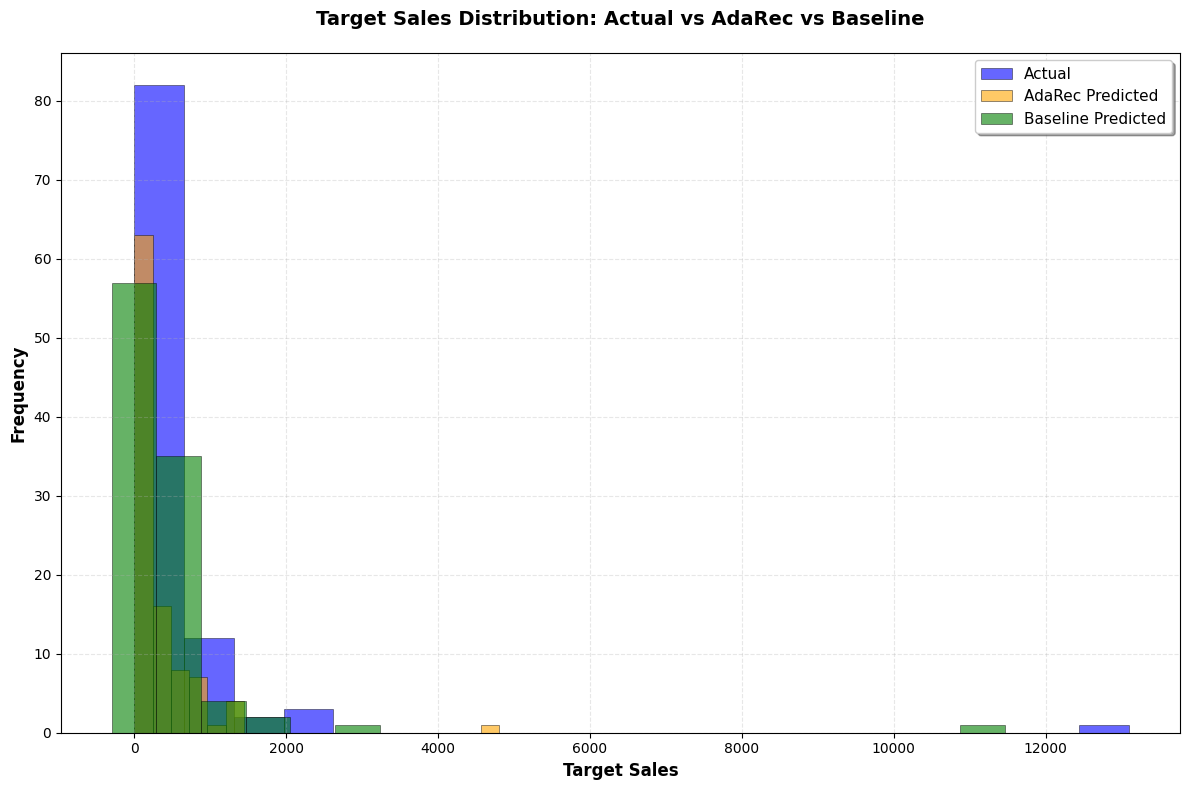

In [102]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot histograms with proper styling
ax.hist(res_df_cat['TargetSales'], alpha=0.6, bins=20, 
        label='Actual', color='blue', edgecolor='black', linewidth=0.5)
ax.hist(res_df_cat['pred_TargetSales'], alpha=0.6, bins=20, 
        label='AdaRec Predicted', color='orange', edgecolor='black', linewidth=0.5)
ax.hist(res_df_cat['cat_TargetSales'], alpha=0.6, bins=20, 
        label='Baseline Predicted', color='green', edgecolor='black', linewidth=0.5)

# Styling
ax.set_xlabel('Target Sales', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Target Sales Distribution: Actual vs AdaRec vs Baseline', 
             fontsize=14, fontweight='bold', pad=20)

# Legend
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)

# Grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()
plt.show()


## Recommendation with Semantic Similarity to Ideal Product Descriptions

Since we asked the model to output `TargetDescription` as `Product description of the ideal product for this customer`, we can perform semantic search with our product catalog to see which products are closest to this ideal product and recommend to each customer.

In our example, the ideal product description was `Home decor and organizational items (doormats, garden accessories, hot water bottles, decorative signs, building block words)` which looked up `HOT WATER BOTTLE I AM SO POORLY` as the most semantically close item. The customer ended up actually purchasing it!

In [109]:
from sentence_transformers import SentenceTransformer
from src.counterfactual.similarity_searcher import SimilaritySearcher

# Load embedding model
model = SentenceTransformer('NovaSearch/stella_en_1.5B_v5')

#load product embeddings
product_df = pl.read_csv('../data/product_description_category_emb.csv')
# initialize SimilaritySearcher
similarity_features = [f'emb_{i}' for i in range(1024)]
searcher = SimilaritySearcher(product_df, similarity_features=similarity_features)

In [123]:
#transform text queries to embeddings
q = res_df['pred_TargetDescription'][67]
emb = model.encode(q)
emb_dict = {f'emb_{i}': emb[i] for i in range(1024)}

In [126]:
#this customer profile
pretty_print(batch_generator.narrative_profile_dataset[67]['narrative_profile'])

Customer 14691 is a highly engaged customer with 142 days of membership (30th
  percentile) and four purchase occasions. Their most recent purchase was just 1
  day ago, placing them at the 10th percentile for recency and indicating peak
  current engagement. With total sales of £1,769.07 (80th percentile) and an
  average basket size of £442.27 (50th percentile), they demonstrate strong
  monetary value. They've purchased 50 distinct products across 8 categories -
  maximum category breadth - showing exceptional product exploration. Their
  category preferences are remarkably balanced: Home Decor (37.7%), Kitchen and
  Dining (10.7%), Stationary and Gifts (10.7%), Fashion Accessories (10.3%),
  Personal Care (10.4%), Seasonal/Holiday (9.8%), Outdoor and Garden (9.5%), and
  Toys and Games (0.8%). The purchase history reveals interest in doormats, herb
  markers, garden items, lunch bags, hot water bottles, and decorative signs
  with humorous or inspirational messages. Their purchase 

In [ ]:
#the customer is determined to have this ideal product
pretty_print(q)

Home decor and organizational items (doormats, garden accessories, hot water
  bottles, decorative signs, building block words)


In [129]:
#which results in these closest products in our catalog
[i['Description'] for i in searcher.search(emb_dict)]

['HOT WATER BOTTLE I AM SO POORLY',
 'RED WHITE SCARF  HOT WATER BOTTLE',
 'CERAMIC CAKE BOWL + HANGING CAKES',
 'CHARLIE LOLA BLUE HOT WATER BOTTLE ',
 'CERAMIC CAKE STAND + HANGING CAKES']

In [ ]:
#what the customer actually purchased
pretty_print(df.filter(pl.col("customer_id") == "14691")['TargetDescriptions'][0])

VINTAGE  2 METRE FOLDING RULER|GARDENERS KNEELING PAD KEEP CALM |GARDENERS
  KNEELING PAD CUP OF TEA |WHITE SKULL HOT WATER BOTTLE |CHOCOLATE HOT WATER
  BOTTLE|HOT WATER BOTTLE KEEP CALM|HOT WATER BOTTLE I AM SO POORLY|DOORMAT KEEP
  CALM AND COME IN|PACK OF SIX LED TEA LIGHTS
